In [831]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
rcParams['figure.figsize'] = 8, 8
rcParams['figure.dpi'] = 100
import os

output_folder = 'C:/Dev/python_variance_bias_trade_off/'
output_folder_plots  = output_folder+'plots/' # folder for plot outcomes
os.makedirs(output_folder_plots,exist_ok=True)

SAVE_OUTPUT = 1 # save the resulting plots
TYPE        = 'highly_non_linear' # linear, non_linear, highly_non_linear
fontsize    = 20
linewidth   = 2

c:\Users\G\anaconda3\envs\py311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


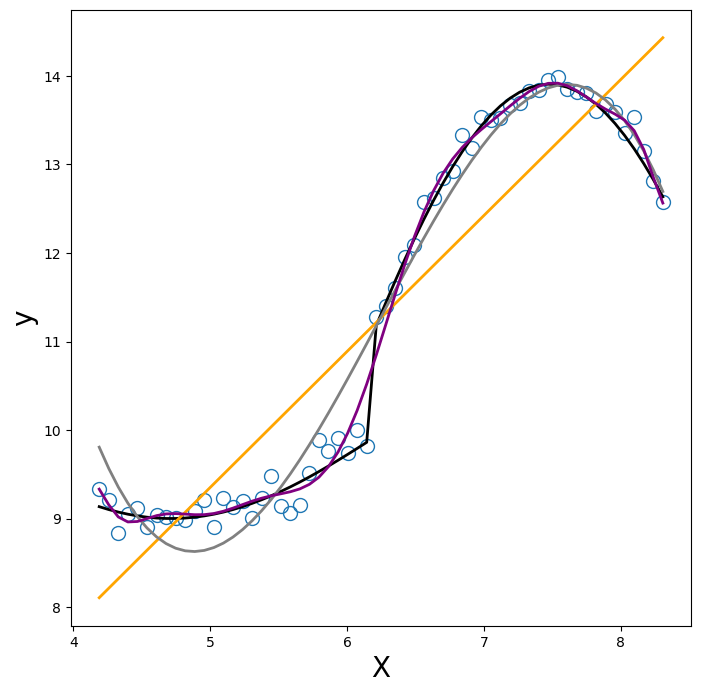

In [832]:
np.random.seed(10)
n_reps = 30 # number of repetitions
x = np.array([np.pi + i*np.pi/180 for i in range(60,300,4)])
n = len(x)
error_sd = 0.15
y_expected = np.sin(x) + 1

if TYPE =='linear':
       y_expected = x + 2

if TYPE =='highly_non_linear':
       y_expected = np.sin(x) + 10 + 3*np.sin(x+.5)*(x>6.2)

error = { i:np.random.normal(0, error_sd, n) for i in range(n_reps)}
y   = y_expected + error[0]
curve = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(curve['x'],curve['y'],'o', markersize=10, fillstyle='none', label='Beobachtungen', linewidth=linewidth )

plt.ylabel('y',fontsize=fontsize)
plt.xlabel('X',fontsize=fontsize)

if TYPE =='linear':
       plt.legend(bbox_to_anchor=(0, 1),
              loc='upper left',
              borderaxespad=0.,fontsize=fontsize)

if SAVE_OUTPUT:
       plt.savefig(output_folder_plots  +'Beobachtungen_0_'+TYPE+'.pdf',bbox_inches="tight")
       #plt.savefig(output_folder_plots  +'Beobachtungen_'+TYPE+ '.png',bbox_inches="tight")


plt.plot( curve['x'],
       y_expected,
       label='Funktion f',
       color = 'black', linewidth=linewidth)

if TYPE =='linear':
       plt.legend(bbox_to_anchor=(0, 1),
              loc='upper left',
              borderaxespad=0.,fontsize=fontsize)


if SAVE_OUTPUT:
       plt.savefig(output_folder_plots  +'Beobachtungen_'+TYPE+'.pdf',bbox_inches="tight")
       #plt.savefig(output_folder_plots  +'Beobachtungen_'+TYPE+ '.png',bbox_inches="tight")


p = np.polyfit( curve.x, curve.y, deg = 1 )
curve['fit'] = np.polyval( p, curve.x )
plt.plot( curve.x, curve.fit, 
         label='Linearer Fit', color= 'orange', linewidth=linewidth)

p = np.polyfit( curve.x, curve.y, deg = 3 )
curve['fit'] = np.polyval( p, curve.x )
plt.plot( curve.x, curve.fit, 
         label='Polynomialer Fit (Grad 3)', color= 'grey', linewidth=linewidth)

p = np.polyfit( curve.x, curve.y, deg = 15 )
curve['fit'] = np.polyval( p, curve.x )
plt.plot( curve.x, curve.fit, 
         label='Polynomialer Fit (Grad 15)', color= 'purple', linewidth=linewidth)

if TYPE =='linear':
       plt.legend(bbox_to_anchor=(0, 1),
              loc='upper left',
              borderaxespad=0.,fontsize=fontsize)


if SAVE_OUTPUT:
       plt.savefig(output_folder_plots  +'Beobachtungen_mit_fit_'+TYPE+'.pdf',bbox_inches="tight")
       #plt.savefig(output_folder_plots  +'Beobachtungen_mit_fit_'+TYPE+ '.png',bbox_inches="tight")


In [833]:
np.random.seed(10)
# test set
inx_test = np.random.choice(range(n), int(n*0.40), replace=False)
# training set
mask = np.ones(n, dtype=bool)
mask[inx_test] = False
inx_train = np.array(range(n))[mask]


# select the training data:
train_X = x[inx_train]

# select the test data:
test_X = x[inx_test]

In [834]:
max_poly = 16

# initialize the metric array:
metrics_df = pd.DataFrame( columns = ["degree", 
                                      "mse_train", "diff_to_check_sum_train", "var_train",  "bias_sq_train", "var_error_train", 
                                      "mse_test",  "diff_to_check_sum_test",  "var_test",   "bias_sq_test",  "var_error_test",] )

# iterate over polynomial degrees:
for i in range( 0, max_poly ):

    # initialize the prediction result array:
    reps_df = np.empty((n, 4, n_reps)) #pd.DataFrame( columns = [  "fit",  "error_fit_sq", "bias", "error"] )

    # iterate over repetitions:
    for r in  range( 0, n_reps ): 

        # generate the data:
        y   = y_expected + error[r]   

        # select the training data:
        train_y = y[inx_train]

        # fit the model:
        p = np.polyfit( train_X, train_y, deg = i+1 )

        # predict:
        predict_y_train = np.polyval( p, train_X )
        predict_y_test  = np.polyval( p, test_X )
        
        # select the test data:
        test_y = y[inx_test]    

        # store the training results:
        reps_df[inx_train,:,r] = np.array([ (train_y - predict_y_train)**2, predict_y_train, predict_y_train - y_expected[inx_train], error[r][inx_train]**2   ]).T

        # # store the test results:
        reps_df[inx_test,:,r] = np.array([ (test_y - predict_y_test)**2, predict_y_test, predict_y_test - y_expected[inx_test] , error[r][inx_test]**2 ]).T

    fit_mse_train    = np.mean(reps_df[inx_train,0,:].mean(axis=1))
    fit_var_train    = np.mean(reps_df[inx_train,1,:].var(axis=1))  
    #fit_var_train    = reps_df[inx_train,1,:].mean(axis=1)
    #fit_var_train    = np.mean(np.mean((reps_df[inx_train,1,:] - fit_var_train.reshape((-1,1) ))**2))
    fit_bias_train   = np.mean(reps_df[inx_train,2,:].mean(axis=1)**2)
    error_var_train  = np.mean(reps_df[inx_train,3,:].mean(axis=1))

    fit_mse_test    = np.mean(reps_df[inx_test,0,:].mean(axis=1))
    fit_var_test    = np.mean(reps_df[inx_test,1,:].var(axis=1))    
    fit_bias_test   = np.mean(reps_df[inx_test,2,:].mean(axis=1)**2)
    error_var_test  = np.mean(reps_df[inx_test,3,:].mean(axis=1))

    metrics_df.loc[i] = [ i+1,
                      # train:
                      fit_mse_train,  
                      fit_mse_train - (fit_var_train + fit_bias_train + error_var_train),   
                      fit_var_train,                       
                      fit_bias_train,  
                      error_var_train,
                      # test
                      fit_mse_test,  
                      fit_mse_test - (fit_var_test+fit_bias_test +error_var_test),
                      fit_var_test, 
                      fit_bias_test, 
                      error_var_test
                    ]
metrics_df    

c:\Users\G\anaconda3\envs\py311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\G\anaconda3\envs\py311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\G\anaconda3\envs\py311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\G\anaconda3\envs\py311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\G\anaconda3\envs\py311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\G\anaconda3\envs\py311\Lib\site-packages\IPython\co

,degree,mse_train,diff_to_check_sum_train,var_train,bias_sq_train,var_error_train,mse_test,diff_to_check_sum_test,var_test,bias_sq_test,var_error_test
0,1.0,0.630629,-0.006495,0.000928,0.615240,0.020955,0.730832,-0.011914,0.000895,0.720945,0.020905
1,2.0,0.621661,-0.007358,0.001744,0.606320,0.020955,0.752252,-0.010319,0.001788,0.739878,0.020905
2,3.0,0.134446,-0.003911,0.002180,0.115222,0.020955,0.150087,-0.001675,0.002236,0.128621,0.020905
3,4.0,0.103253,-0.005034,0.002699,0.084634,0.020955,0.112519,-0.001049,0.002602,0.090061,0.020905
4,5.0,0.061016,-0.006729,0.003200,0.043590,0.020955,0.078738,0.000023,0.003209,0.054602,0.020905
5,6.0,0.057425,-0.008750,0.004029,0.041191,0.020955,0.070860,0.001489,0.003953,0.044514,0.020905
6,7.0,0.043024,-0.011656,0.004538,0.029187,0.020955,0.061447,0.003537,0.005066,0.031939,0.020905
7,8.0,0.042519,-0.012664,0.005043,0.029185,0.020955,0.062336,0.003276,0.006102,0.032053,0.020905
8,9.0,0.035981,-0.013498,0.005570,0.022955,0.020955,0.053760,0.003268,0.006689,0.022898,0.020905
9,10.0,0.035276,-0.014927,0.006246,0.023003,0.020955,0.055667,0.003494,0.008248,0.023020,0.020905


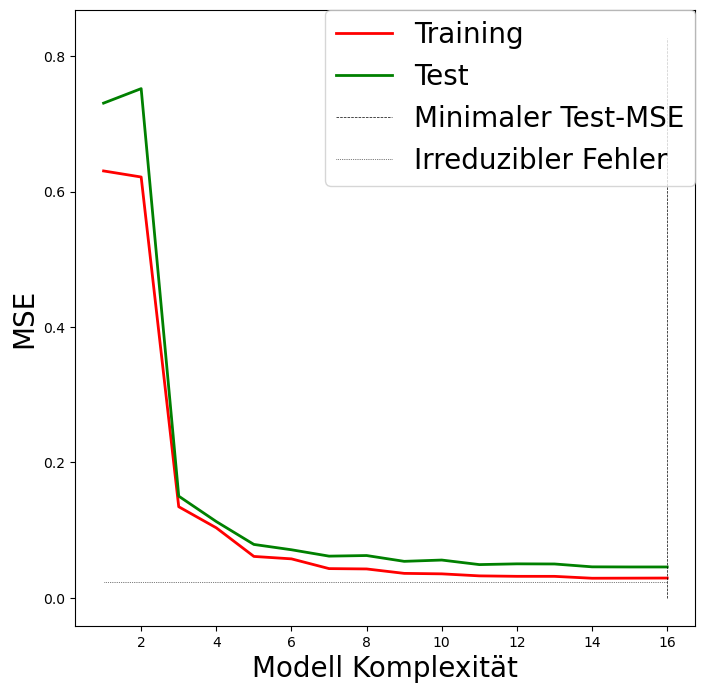

In [835]:
plt.plot( metrics_df.degree,
       metrics_df.mse_train,
       label='Training',
       color = 'r', linewidth=linewidth )

plt.plot( metrics_df.degree,
       metrics_df.mse_test,
       label='Test',
       color = 'g', linewidth=linewidth )

plt.vlines( metrics_df.degree[np.argmin(metrics_df.mse_test)] , 0, max(metrics_df.mse_test)*1.1, color='black', linestyles='dashed', label='Minimaler Test-MSE', linewidth = .5)

plt.hlines( error_sd**2, 1, max_poly , color='black', linestyles='dotted', label='Irreduzibler Fehler', linewidth = .5)

plt.ylabel('MSE',fontsize=fontsize)
plt.xlabel('Modell Komplexität',fontsize=fontsize)

if TYPE =='highly_non_linear':
       plt.legend(bbox_to_anchor=(1, 1),
              loc=1,
              borderaxespad=0.,fontsize=fontsize)

if SAVE_OUTPUT:
       plt.savefig(output_folder_plots  +'MSE_'+TYPE+'.pdf',bbox_inches="tight")
       #plt.savefig(output_folder_plots  +'MSE_'+TYPE+ '.png',bbox_inches="tight")



Text(0.5, 0, 'Modell Komplexität')

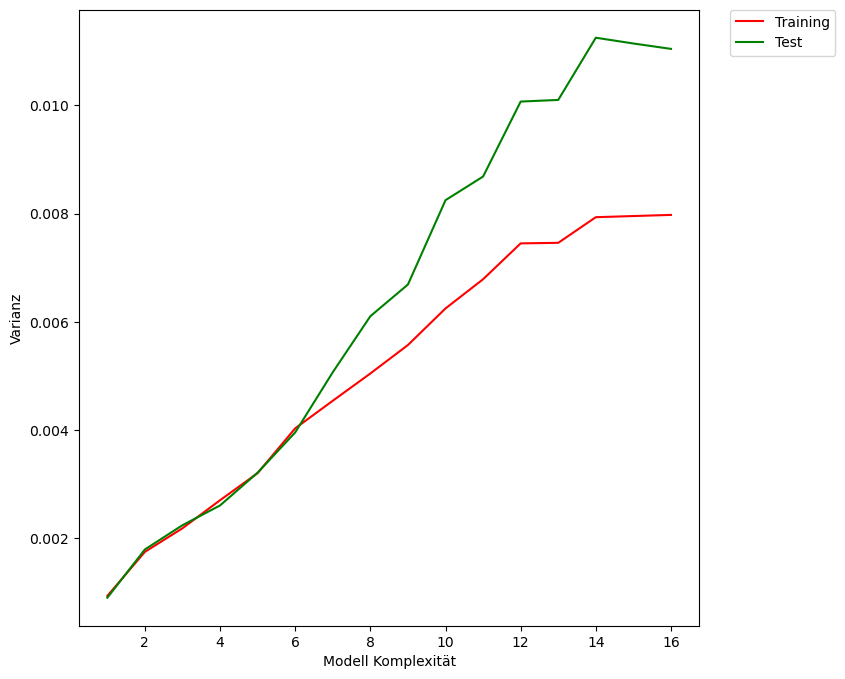

In [836]:
plt.plot( metrics_df.degree,
       metrics_df.var_train,
       label='Training',
       color = 'r' )

plt.plot( metrics_df.degree,
       metrics_df.var_test,
       label='Test',
       color = 'g' )

plt.legend(bbox_to_anchor=(1.05, 1),
         loc=2,
         borderaxespad=0.)

plt.ylabel('Varianz')
plt.xlabel('Modell Komplexität')

Text(0.5, 0, 'Modell Komplexität')

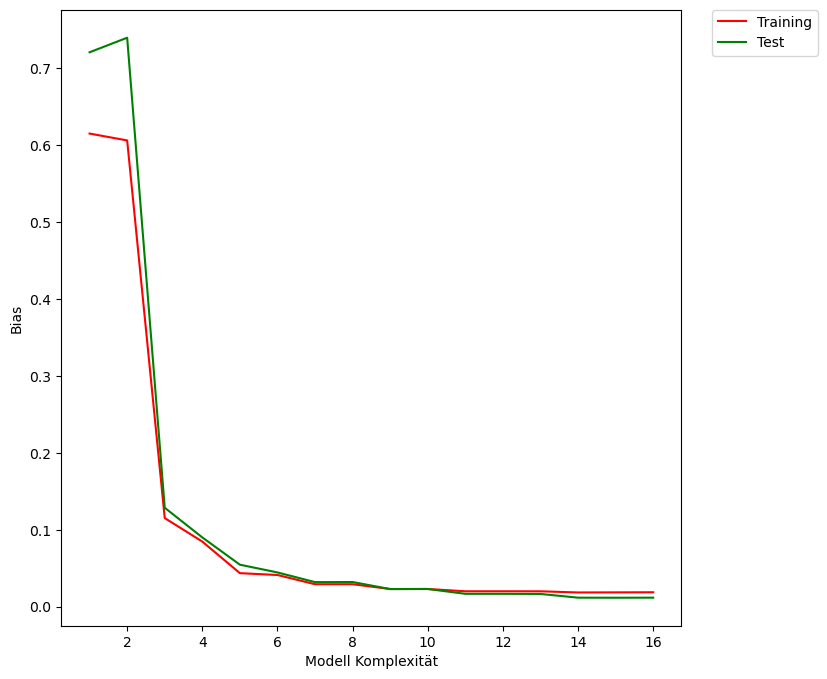

In [837]:
plt.plot( metrics_df.degree,
       metrics_df.bias_sq_train,
       label='Training',
       color = 'r' )

plt.plot( metrics_df.degree,
       metrics_df.bias_sq_test,
       label='Test',
       color = 'g' )

plt.legend(bbox_to_anchor=(1.05, 1),
         loc=2,
         borderaxespad=0.)

plt.ylabel('Bias')
plt.xlabel('Modell Komplexität')

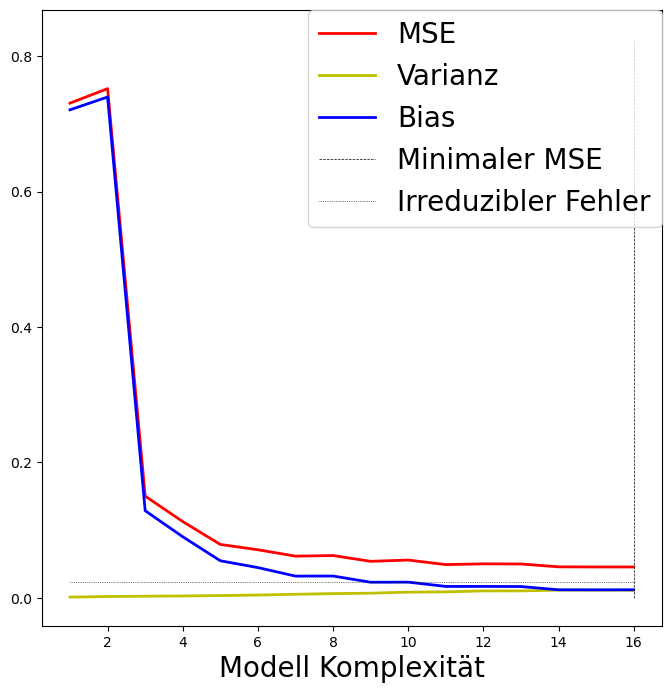

In [838]:
plt.plot( metrics_df.degree,
       metrics_df.mse_test,
       label='MSE',
       color = 'r' , linewidth=linewidth)

plt.plot( metrics_df.degree,
       metrics_df.var_test,
       label='Varianz',
       color = 'y' , linewidth=linewidth)

plt.plot( metrics_df.degree,
       metrics_df.bias_sq_test,
       label='Bias',
       color = 'b' , linewidth=linewidth)


plt.vlines( metrics_df.degree[np.argmin(metrics_df.mse_test)] , 0, max(metrics_df.mse_test)*1.1, color='black', linestyles='dashed', label='Minimaler MSE', linewidth = .5)

plt.hlines( error_sd**2, 1, max_poly , color='black', linestyles='dotted', label='Irreduzibler Fehler', linewidth = .5)

plt.xlabel('Modell Komplexität',fontsize=fontsize)


if TYPE =='highly_non_linear':
       plt.legend(bbox_to_anchor=(1, 1),
              loc=1,
              borderaxespad=0.,fontsize=fontsize)


if SAVE_OUTPUT:
       plt.savefig(output_folder_plots  +'MSE_breakdown_'+TYPE+'.pdf',bbox_inches="tight")
       #plt.savefig(output_folder_plots  +'MSE_breakdown_'+TYPE+ '.png',bbox_inches="tight")
